In [284]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from utils import time_plot, get_figure, acf_plot
import matplotlib.pyplot as plt

## Synthetic Time Series 1

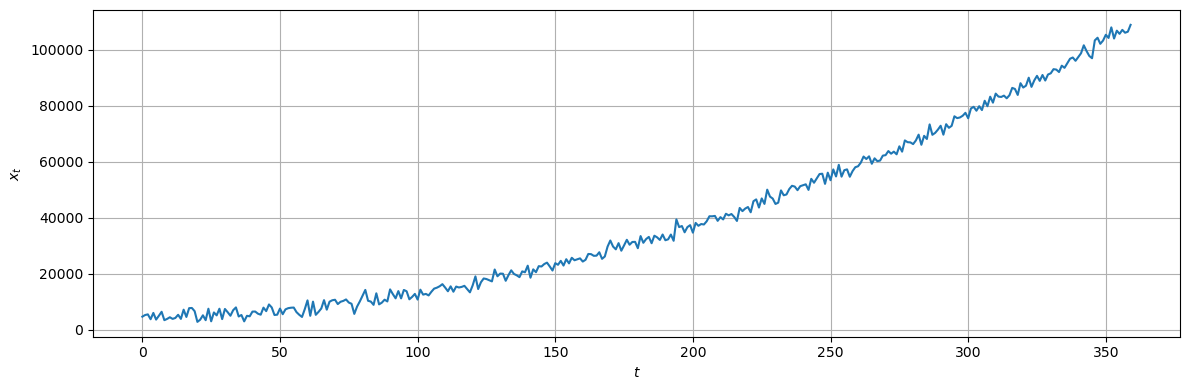

In [299]:
np.random.seed(41)
n_periods = 72
n_years = 5
n_steps = n_periods * n_years
samples = np.arange(n_steps)
noise = 500*np.random.normal(10,3,len(samples))
trend = 1*np.random.randint(1,10)+0.8*(samples**2)
seasonal = 200*np.sin(2*(np.pi/n_periods)*samples+0)
signal = trend + noise + seasonal 
time_plot(samples, signal)


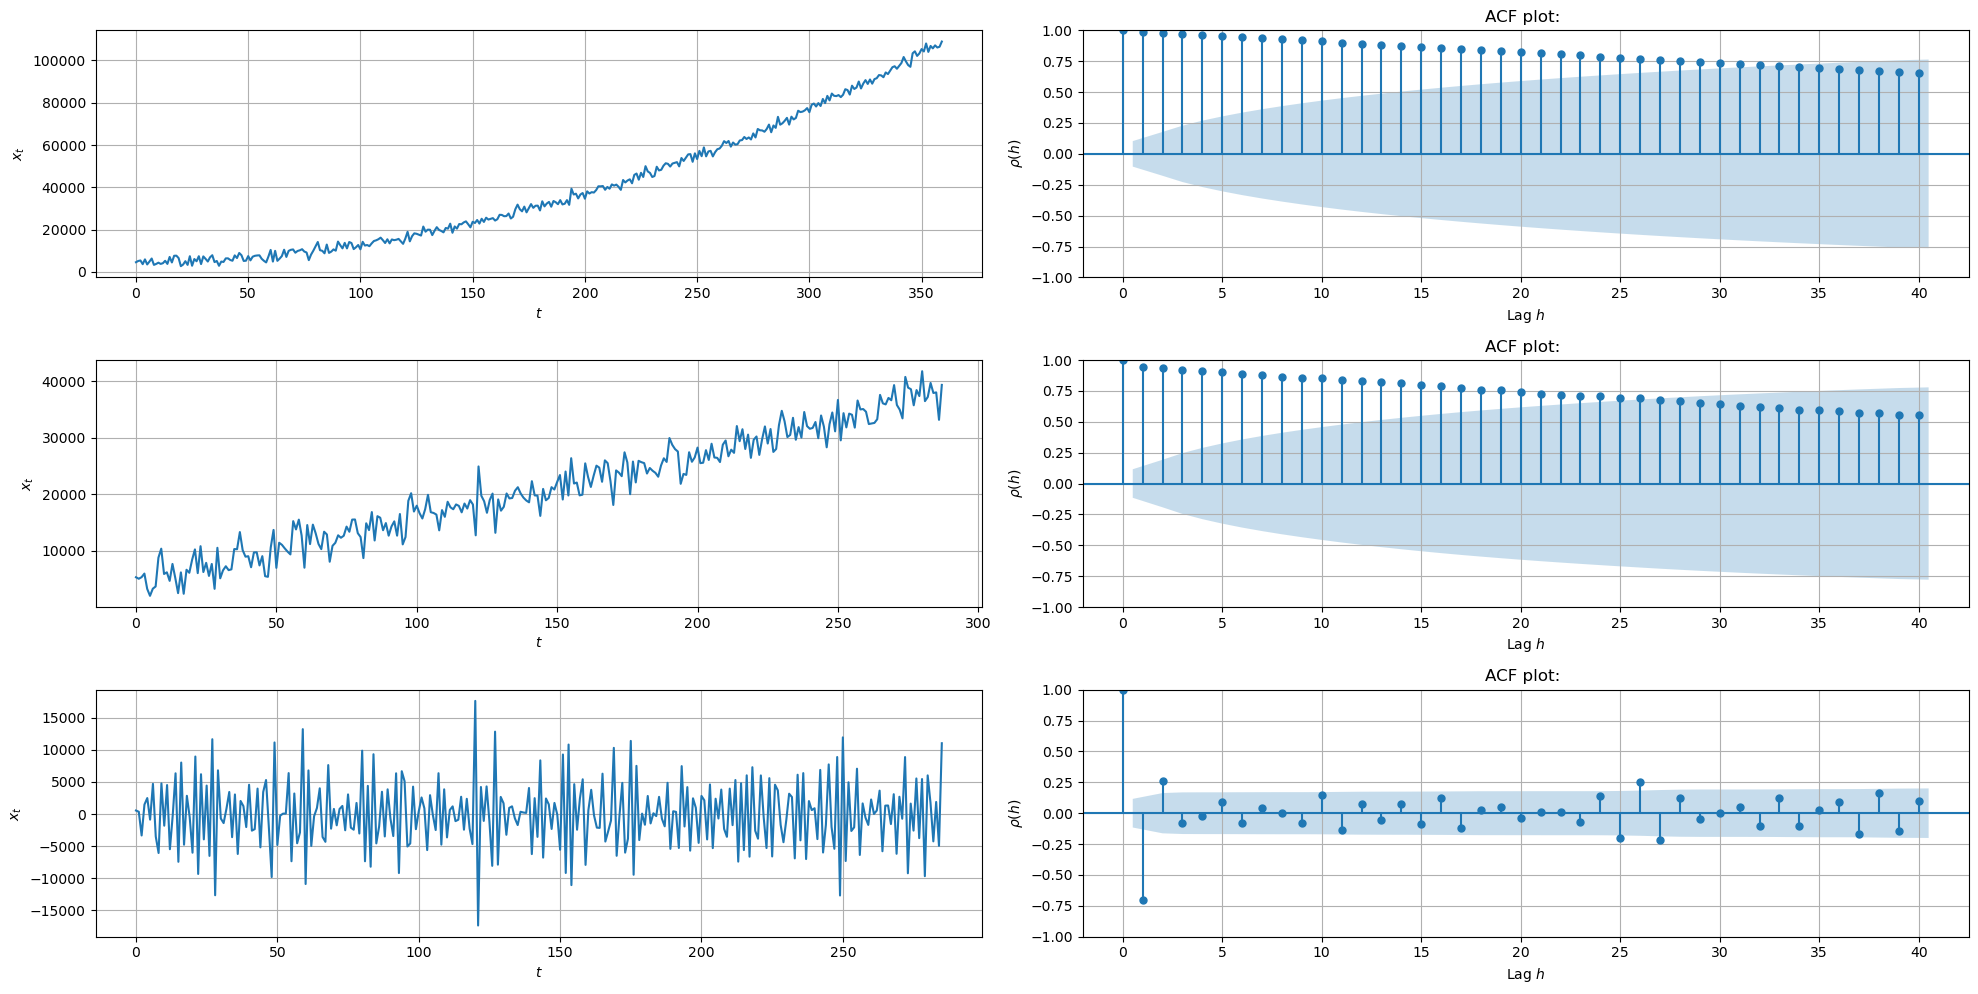

In [301]:
# removing the trend component using differencing 
def differencing(signal: np.ndarray, lag_h: int = 1,order: int = 1) -> np.ndarray:
    """Remove trend component using differencing of specified order."""
    diff = signal[lag_h:] - signal[:-lag_h]
    
    if order > 1:
        return differencing(diff, lag_h=lag_h, order=order - 1)

    return diff

P = 72
signal1 = differencing(signal,P,1)
signal2 = differencing(signal1,1,2)

fig, axs = get_figure(3, 2, figsize = (20,10))

time_plot(np.arange(len(signal)), signal, ax=axs[0])
acf_plot(signal,40, ax=axs[1])


time_plot(np.arange(len(signal1)), signal1, ax=axs[2])
acf_plot(signal1,40, ax=axs[3])

time_plot(np.arange(len(signal2)), signal2, ax=axs[4])
acf_plot(signal2,40, ax=axs[5])

plt.show()

#### Classical Decomposition

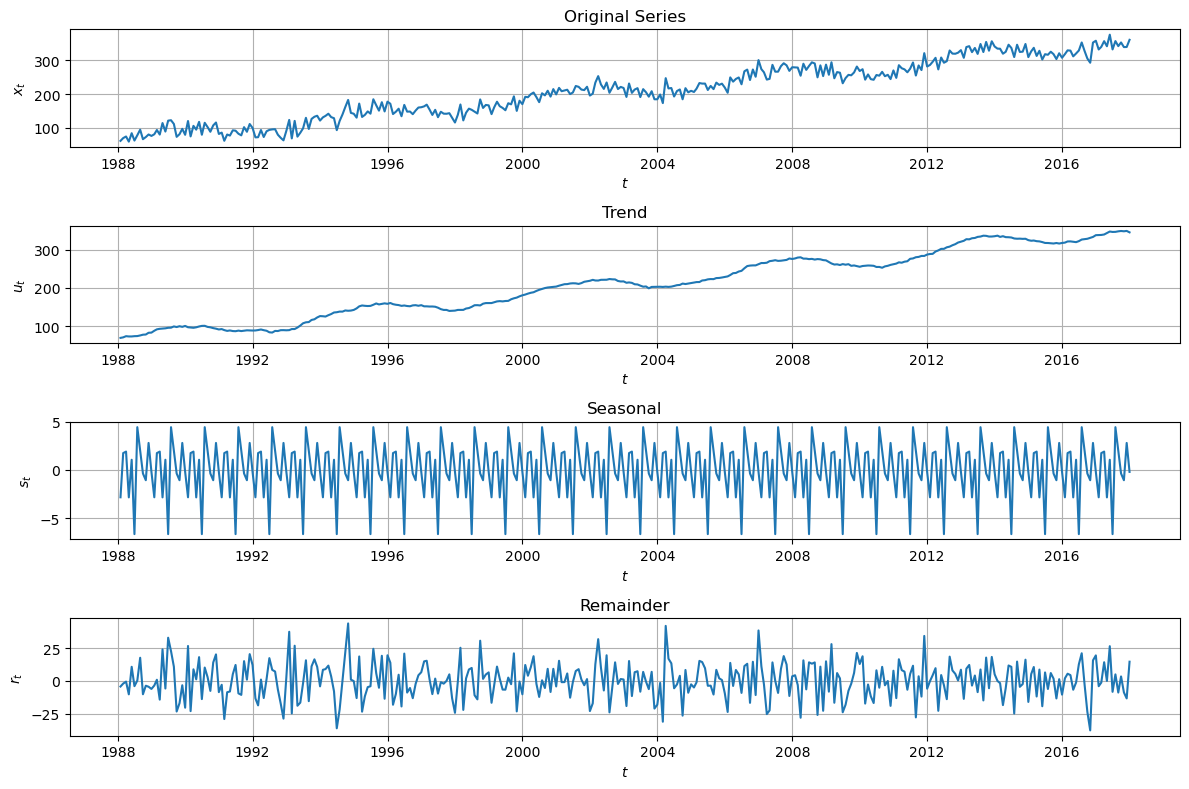

In [174]:

df = pd.DataFrame({'Sales': signal})
df.index = pd.date_range(start='1988-01-01', periods=n_steps, freq='ME')

# Detrend series
df['Trend'] = df['Sales'].rolling(window=12, center=True, min_periods=1).mean()
df['Detrended'] = df['Sales'] - df['Trend']
# Calculate the seasonal components using period adjusted averages
df['Month'] = df.index.month
seasonal_avg = df.groupby('Month')['Detrended'].mean()
# Adjust seasonal components
seasonal_avg_adjusted = seasonal_avg - seasonal_avg.mean()
# Repeat the seasonal component values for each period
df['Seasonal'] = df['Month'].map(seasonal_avg_adjusted)
# Deseasonalize detrended series
df['Remainder'] = df['Detrended'] - df['Seasonal']

fig, [ax1, ax2, ax3, ax4] = get_figure(4, 1, figsize=(12, 8))
time_plot(
    x=df.index,
    y=df['Sales'], 
    title='Original Series',
    ax=ax1
)
time_plot(
    x=df.index,
    y=df['Trend'], 
    title='Trend',
    ax=ax2,
    ylabel='$u_t$',
)
time_plot(
    x=df.index,
    y=df['Seasonal'], 
    title='Seasonal',
    ax=ax3,
    ylabel='$s_t$',
)
time_plot(
    x=df.index,
    y=df['Remainder'], 
    title='Remainder',
    ax=ax4,
    ylabel='$r_t$',
)
fig.tight_layout()

#### STL Decomposition

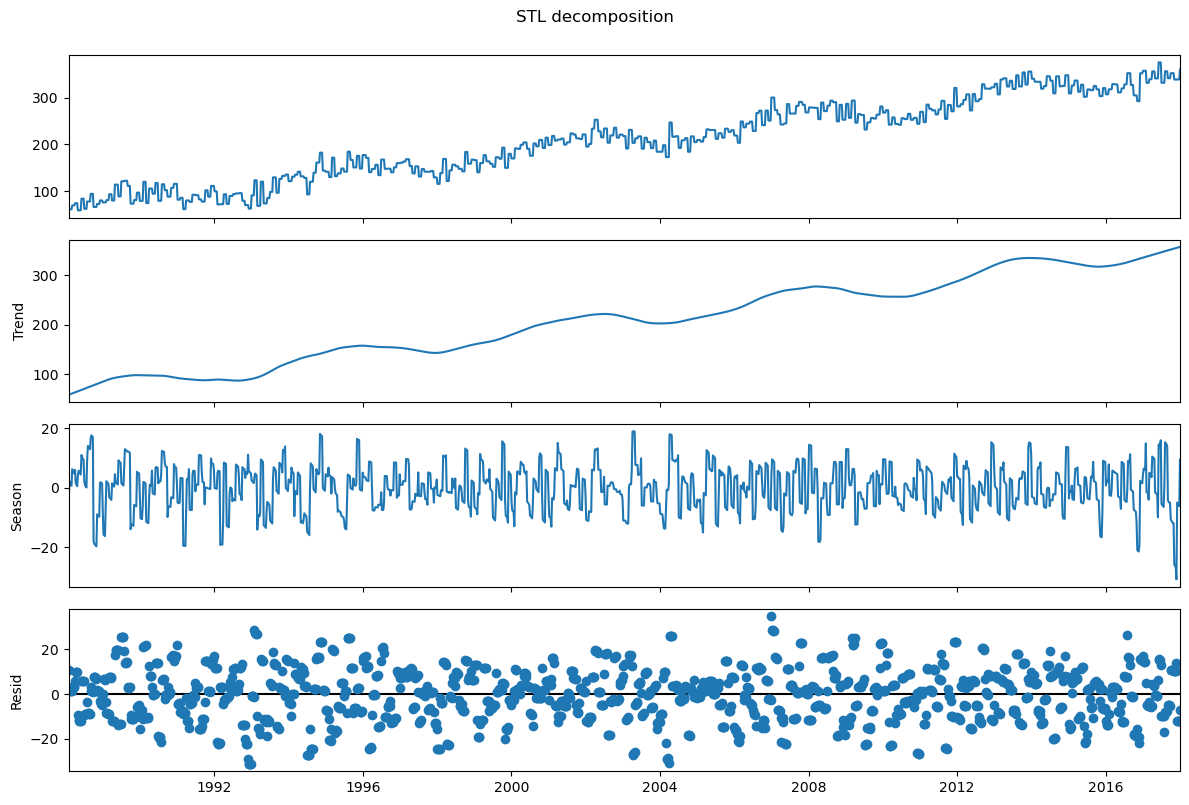

In [180]:
data = df['Sales']
data = data.resample('W').mean().ffill()
res = STL(data).fit()
fig = res.plot()
fig.axes[0].set_title("")
fig.set_size_inches(12, 8)
fig.suptitle("STL decomposition", y=1)
fig.tight_layout()